<a href="https://colab.research.google.com/github/chohayden/CSCI-167-Final-Project/blob/main/167final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install datasets -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from datasets import load_dataset, disable_progress_bar
import matplotlib.pyplot as plt
import numpy as np


disable_progress_bar()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


print("Downloading CIFAR-10 via Hugging Face...")
dataset = load_dataset("cifar10")


stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])


def transform_images(examples):
    examples['pixel_values'] = [transform(image) for image in examples['img']]

    return {
        'pixel_values': examples['pixel_values'],
        'label': examples['label']
    }

# Apply transform
dataset.set_transform(transform_images)

BATCH_SIZE = 128

train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Loaded: {len(dataset['train'])} training images, {len(dataset['test'])} test images.")

Using device: cuda
Data Loaded: 50000 training images, 10000 test images.


In [7]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 16x16
            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 8x8
            # Layer 3
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 10) # 10 Classes
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def get_resnet18():
    # Load standard ResNet18
    model = resnet18(weights=None) # No pre-training (Fair comparison)


    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() # Remove maxpool

    # Modify output layer for 10 classes
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [8]:
def train_model(model_name, model, optimizer_name, learning_rate=0.001, epochs=10):
    print(f"\n--- Training {model_name} with {optimizer_name} ---")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Select Optimizer dynamically
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training Step
        for batch in train_loader:
            # Hugging Face datasets return dicts; extract tensors
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation Step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history


--- Training SimpleCNN with Adam ---
Epoch [1/10] Loss: 1.5089 | Val Acc: 53.67%
Epoch [2/10] Loss: 1.1177 | Val Acc: 64.07%
Epoch [3/10] Loss: 0.9412 | Val Acc: 68.10%
Epoch [4/10] Loss: 0.8344 | Val Acc: 70.17%
Epoch [5/10] Loss: 0.7531 | Val Acc: 71.99%
Epoch [6/10] Loss: 0.6892 | Val Acc: 71.06%
Epoch [7/10] Loss: 0.6404 | Val Acc: 73.40%
Epoch [8/10] Loss: 0.5872 | Val Acc: 72.46%
Epoch [9/10] Loss: 0.5483 | Val Acc: 73.18%
Epoch [10/10] Loss: 0.5092 | Val Acc: 73.31%

--- Training ResNet18 with Adam ---
Epoch [1/10] Loss: 1.2022 | Val Acc: 67.80%
Epoch [2/10] Loss: 0.7120 | Val Acc: 77.08%
Epoch [3/10] Loss: 0.5229 | Val Acc: 79.63%
Epoch [4/10] Loss: 0.3911 | Val Acc: 75.94%
Epoch [5/10] Loss: 0.2942 | Val Acc: 80.27%
Epoch [6/10] Loss: 0.2132 | Val Acc: 80.72%
Epoch [7/10] Loss: 0.1458 | Val Acc: 82.13%
Epoch [8/10] Loss: 0.1049 | Val Acc: 80.63%
Epoch [9/10] Loss: 0.0882 | Val Acc: 82.95%
Epoch [10/10] Loss: 0.0764 | Val Acc: 80.68%

--- Training ResNet18 (SGD) with SGD ---
E

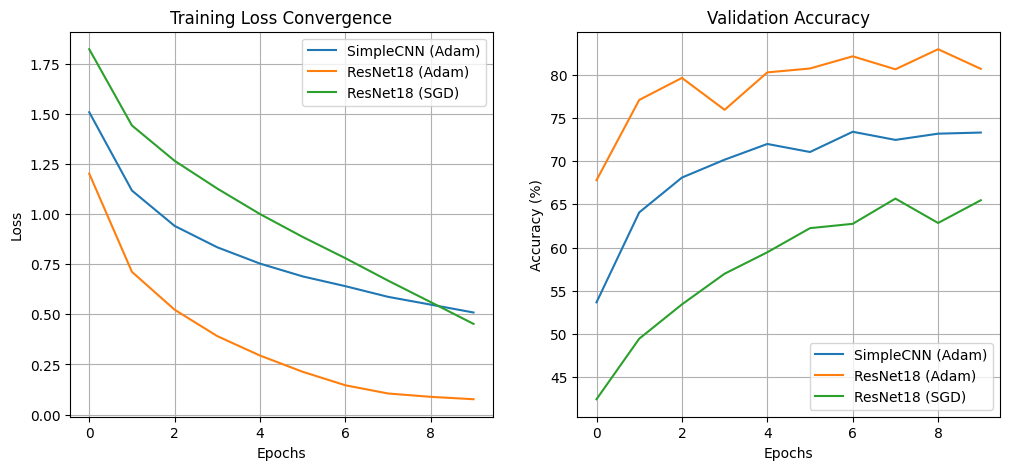

In [9]:
# Experiment 1: Simple CNN (Adam)
cnn_model = SimpleCNN()
cnn_history = train_model("SimpleCNN", cnn_model, "Adam", epochs=10)

# Experiment 2: ResNet18 (Adam)
resnet_adam = get_resnet18()
resnet_adam_history = train_model("ResNet18", resnet_adam, "Adam", epochs=10)

# Experiment 3: ResNet18 (SGD) - Showing Hyperparameter impact
resnet_sgd = get_resnet18()
resnet_sgd_history = train_model("ResNet18 (SGD)", resnet_sgd, "SGD", epochs=10)

plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history['train_loss'], label='SimpleCNN (Adam)')
plt.plot(resnet_adam_history['train_loss'], label='ResNet18 (Adam)')
plt.plot(resnet_sgd_history['train_loss'], label='ResNet18 (SGD)')
plt.title('Training Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history['val_acc'], label='SimpleCNN (Adam)')
plt.plot(resnet_adam_history['val_acc'], label='ResNet18 (Adam)')
plt.plot(resnet_sgd_history['val_acc'], label='ResNet18 (SGD)')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()